In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization
from keras.layers.core import Lambda
from keras.models import Model , load_model

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


## Carga y distribución de datos

In [2]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])

In [3]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [4]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra, axis = 2)
Y = np.expand_dims(parallax, axis = 1)
K_mag = np.expand_dims(Kmag, axis = 1)

# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag)
Gmag_mean = np.mean(Gmag)
Gmag_norm = (Gmag - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
bp_rp_norm = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
teff_norm = (teff - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)

X_offset = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1) 

In [5]:
print(X.shape , Y.shape, K_mag.shape, X_offset.shape)

(60986, 7514, 1) (60986, 1) (60986, 1) (60986, 3)


#### SNR cut

In [6]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr)):
    if snr[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(10)
random.shuffle(high_snr_idx)
random.seed(60)
random.shuffle(low_snr_idx)

#### Estos valores pueden ser comparados con Bovy train-test separation, 

Apart from taht we should be more clear about data preparation and evaluation

get consistent and repeatable accuracy using train and validation approach <br>
undestand the process of validation (draft about probability_distributions) <br> 
check the precision on the test data using baseline separation <br>
compute learning curve, following Fig 1. of Nguyen et. al.<br>
try with percentual mse, such that low and high parallax values weight the same <br>

initially we can consider SNR>200 for train-valid and SNR<200 for test <br>
understand why it is possible to make this separation and hope for consistent results <br>

compare to Bovy using this data separation, using global precision and learning curve<br>

How well are we doing with respect to Bovy?

In [ ]:
#Image("/home/bapanes/Research-Now/TesisAnell/Figures/learning_curve_genoma.png")
Image("learning_curve_genoma.png")

In [8]:
print("SNR>200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR>200: 27721, else: 33265


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  177 (train) + 44 (valid) = 221

train_val_2 $\rightarrow$  400 (train) + 100 (valid) = 500

train_val_3 $\rightarrow$  800 (train) + 200 (valid) = 1000

train_val_4 $\rightarrow$  2400 (train) + 600 (valid) = 3000

train_val_5 $\rightarrow$  6400 (train) + 1600 (valid) = 8000

train_val_6 $\rightarrow$  12000 (train) + 3000 (valid) = 15000

train_val_7 $\rightarrow$  22177 (train) + 5594 (valid) = 27771

test $\rightarrow$ 33265

In [9]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_high_snr = X_offset[high_snr_idx]

X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_low_snr = X_offset[low_snr_idx]

In [10]:
X_train_val_1 = X_high_snr[:221]
Y_train_val_1 = Y_high_snr[:221]
K_mag_train_val_1 = K_mag_high_snr[:221]
X_offset_train_val_1 = X_offset_high_snr[:221]

X_train_val_2 = X_high_snr[221:721]
Y_train_val_2 = Y_high_snr[221:721]
K_mag_train_val_2 = K_mag_high_snr[221:721]
X_offset_train_val_2 = X_offset_high_snr[221:721]

X_train_val_3 = X_high_snr[721:1721]
Y_train_val_3 = Y_high_snr[721:1721]
K_mag_train_val_3 = K_mag_high_snr[721:1721]
X_offset_train_val_3 = X_offset_high_snr[721:1721]

X_train_val_4 = X_high_snr[1721:4721]
Y_train_val_4 = Y_high_snr[1721:4721]
K_mag_train_val_4 = K_mag_high_snr[1721:4721]
X_offset_train_val_4 = X_offset_high_snr[1721:4721]

X_train_val_5 = X_high_snr[4721:12721]
Y_train_val_5 = Y_high_snr[4721:12721]
K_mag_train_val_5 = K_mag_high_snr[4721:12721]
X_offset_train_val_5 = X_offset_high_snr[4721:12721]

X_train_val_6 = X_high_snr[12721:]
Y_train_val_6 = Y_high_snr[12721:]
K_mag_train_val_6 = K_mag_high_snr[12721:]
X_offset_train_val_6 = X_offset_high_snr[12721:]

X_train_val_7 = X_high_snr
Y_train_val_7 = Y_high_snr
K_mag_train_val_7 = K_mag_high_snr
X_offset_train_val_7 = X_offset_high_snr

X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_test = X_offset_low_snr
snr_test = snr[low_snr_idx]

In [11]:
print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , 
      Y_train_val_5.shape,Y_train_val_6.shape ,Y_train_val_7.shape , Y_test.shape)

(221, 1) (500, 1) (1000, 1) (3000, 1) (8000, 1) (15000, 1) (27721, 1) (33265, 1)


## Carga de modelos

In [12]:
path_local_models = '/home/anell/Desktop/Bovy/AnellExercises/Good_Models/'

#No consideraré los modelos 1 y 2 porque se entrenaron con muy pocos datos

model_3 = load_model(f'{path_local_models}/Modelo_1_200epoch_D3_ReplicaBovy.h5',custom_objects={'tf': tf}) #1000
model_4 = load_model(f'{path_local_models}/Modelo_1_200epoch_D4_ReplicaBovy.h5',custom_objects={'tf': tf}) #3000
model_5 = load_model(f'{path_local_models}/Modelo_1_200epoch_D5_ReplicaBovy.h5',custom_objects={'tf': tf}) #8000
model_6 = load_model(f'{path_local_models}/Modelo_1_200epoch_D6_ReplicaBovy.h5',custom_objects={'tf': tf}) #15000
model_7 = load_model(f'{path_local_models}/Modelo_1_200epoch_D7_ReplicaBovy.h5',custom_objects={'tf': tf}) #27771

### Evaluación inicial

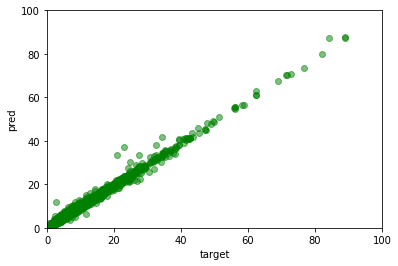

In [64]:
plt.scatter(Y_train_val_7, Y_train_hat, c="g", alpha=0.5)

plt.xlabel("target")
plt.ylabel("pred")

plt.ylim(0,100)
plt.xlim(0,100)
plt.show()

### Curva de aprendizaje 1 (MSE vs tamaño set de entrenamiento)

In [42]:
J_test_m3, mse_test_m3 = model_3.evaluate([X_test,K_mag_test,X_offset_test], Y_test)
J_test_m4, mse_test_m4 = model_4.evaluate([X_test,K_mag_test,X_offset_test], Y_test)
J_test_m5, mse_test_m5 = model_5.evaluate([X_test,K_mag_test,X_offset_test], Y_test)
J_test_m6, mse_test_m6 = model_6.evaluate([X_test,K_mag_test,X_offset_test], Y_test)
J_test_m7, mse_test_m7 = model_7.evaluate([X_test,K_mag_test,X_offset_test], Y_test)

33265/33265 [==============================] - 12s 357us/step


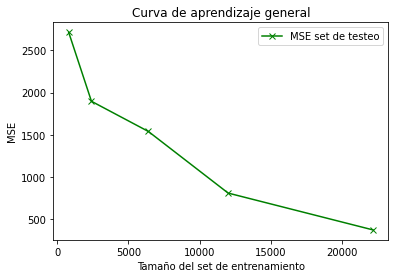

In [44]:
mse_test = [mse_test_m3,mse_test_m4,mse_test_m5,mse_test_m6, mse_test_m7]
m_train = [int(0.8*len(Y_train_val_3)), int(0.8*len(Y_train_val_4)),int(0.8*len(Y_train_val_5)),
           int(0.8*len(Y_train_val_6)),int(0.8*len(Y_train_val_7))]

plt.plot(m_train, mse_test, "xg-", label = "MSE set de testeo")
plt.ylabel("MSE")
plt.xlabel("Tamaño del set de entrenamiento")
plt.title("Curva de aprendizaje general")
plt.legend()
plt.show()

### Curva de aprendizaje 2 (MSE versus SNR)

In [20]:
snr_0_100 = []
snr_100_150 = []
snr_150_200 = []

for i in range(len(snr_test)):
    if snr_test[i] <= 100:
        snr_0_100.append(i)
    elif 100 < snr_test[i] <= 150:
        snr_100_150.append(i)
    else:
        snr_150_200.append(i)

print(len(snr_0_100) , len(snr_100_150) , len(snr_150_200) )

7983 14842 10440


In [21]:
X_test_snr_0_100 = X_test[snr_0_100]
Y_test_snr_0_100 = Y_test[snr_0_100]
K_mag_test_snr_0_100 = K_mag_test[snr_0_100]
X_offset_test_snr_0_100 = X_offset_test[snr_0_100]

X_test_snr_100_150 = X_test[snr_100_150]
Y_test_snr_100_150 = Y_test[snr_100_150]
K_mag_test_snr_100_150 = K_mag_test[snr_100_150]
X_offset_test_snr_100_150 = X_offset_test[snr_100_150]

X_test_snr_150_200 = X_test[snr_150_200]
Y_test_snr_150_200 = Y_test[snr_150_200]
K_mag_test_snr_150_200 = K_mag_test[snr_150_200]
X_offset_test_snr_150_200 = X_offset_test[snr_150_200]

In [22]:
print( Y_test_snr_0_100.shape , Y_test_snr_100_150.shape , Y_test_snr_150_200.shape)

(7983, 1) (14842, 1) (10440, 1)


In [25]:
#Evaluación modelo 7
J_test_m7_snr_0_100, mse_test_m7_snr_0_100 = model_7.evaluate([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100], Y_test_snr_0_100)
J_test_m7_snr_100_150, mse_test_m7_snr_100_150 = model_7.evaluate([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150], Y_test_snr_100_150)
J_test_m7_snr_150_200, mse_test_m7_snr_150_200 = model_7.evaluate([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200], Y_test_snr_150_200)

mse_test_m7_snr = [ mse_test_m7_snr_0_100 , mse_test_m7_snr_100_150 , mse_test_m7_snr_150_200]

print("mse's modelo 7: ", mse_test_m7_snr)   #mientras más cercano esté el SNR a 200, más confiable será la predicción

10440/10440 [==============================] - 4s 346us/step
mse's modelo 7:  [1513.07275390625, 19.262081146240234, 0.16720686852931976]


In [26]:
J_test_m6_snr_0_100, mse_test_m6_snr_0_100 = model_6.evaluate([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100], Y_test_snr_0_100)
J_test_m6_snr_100_150, mse_test_m6_snr_100_150 = model_6.evaluate([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150], Y_test_snr_100_150)
J_test_m6_snr_150_200, mse_test_m6_snr_150_200 = model_6.evaluate([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200], Y_test_snr_150_200)

mse_test_m6_snr = [mse_test_m6_snr_0_100 , mse_test_m6_snr_100_150 , mse_test_m6_snr_150_200]

print("mse's modelo 6: ", mse_test_m6_snr) 

10440/10440 [==============================] - 4s 343us/step
mse's modelo 6:  [3329.32421875, 21.355886459350586, 0.19424039125442505]


In [27]:
J_test_m5_snr_0_100, mse_test_m5_snr_0_100 = model_5.evaluate([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100], Y_test_snr_0_100)
J_test_m5_snr_100_150, mse_test_m5_snr_100_150 = model_5.evaluate([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150], Y_test_snr_100_150)
J_test_m5_snr_150_200, mse_test_m5_snr_150_200 = model_5.evaluate([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200], Y_test_snr_150_200)

mse_test_m5_snr = [ mse_test_m5_snr_0_100 , mse_test_m5_snr_100_150 , mse_test_m5_snr_150_200]

print("mse's modelo 5: ", mse_test_m5_snr) 

10440/10440 [==============================] - 4s 348us/step
mse's modelo 5:  [6183.1748046875, 123.76571655273438, 0.2950790524482727]


In [28]:
J_test_m4_snr_0_100, mse_test_m4_snr_0_100 = model_4.evaluate([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100], Y_test_snr_0_100)
J_test_m4_snr_100_150, mse_test_m4_snr_100_150 = model_4.evaluate([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150], Y_test_snr_100_150)
J_test_m4_snr_150_200, mse_test_m4_snr_150_200 = model_4.evaluate([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200], Y_test_snr_150_200)

mse_test_m4_snr = [ mse_test_m4_snr_0_100 , mse_test_m4_snr_100_150 , mse_test_m4_snr_150_200]
print("mse's modelo 4: ", mse_test_m4_snr) 

10440/10440 [==============================] - 4s 345us/step
mse's modelo 4:  [7582.568359375, 173.55438232421875, 0.44381800293922424]


In [29]:
J_test_m3_snr_0_100, mse_test_m3_snr_0_100 = model_3.evaluate([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100], Y_test_snr_0_100)
J_test_m3_snr_100_150, mse_test_m3_snr_100_150 = model_3.evaluate([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150], Y_test_snr_100_150)
J_test_m3_snr_150_200, mse_test_m3_snr_150_200 = model_3.evaluate([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200], Y_test_snr_150_200)

mse_test_m3_snr = [ mse_test_m3_snr_0_100 , mse_test_m3_snr_100_150 , mse_test_m3_snr_150_200]
print("mse's modelo 3: ", mse_test_m3_snr) 

10440/10440 [==============================] - 4s 346us/step
mse's modelo 3:  [10772.1669921875, 292.832275390625, 0.8257049918174744]


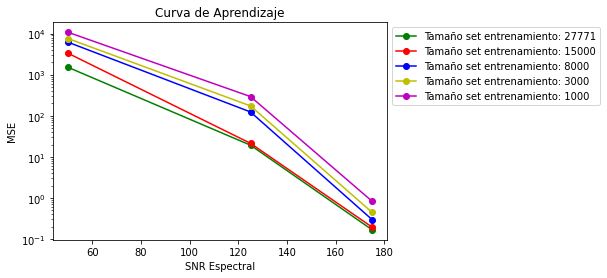

In [30]:
snr_list = [50,125,175]

plt.plot(snr_list, mse_test_m7_snr, "og-", label = "Tamaño set entrenamiento: 27771")   
plt.plot(snr_list, mse_test_m6_snr, "or-", label = "Tamaño set entrenamiento: 15000")   
plt.plot(snr_list, mse_test_m5_snr, "ob-", label = "Tamaño set entrenamiento: 8000")
plt.plot(snr_list, mse_test_m4_snr, "oy-", label = "Tamaño set entrenamiento: 3000")
plt.plot(snr_list, mse_test_m3_snr, "om-", label = "Tamaño set entrenamiento: 1000")

plt.legend(loc= "upper right", bbox_to_anchor=(1.65, 1))
plt.ylabel("MSE")
plt.xlabel("SNR Espectral")
plt.title("Curva de Aprendizaje")
plt.yscale("log")
plt.show()

### TAREAS
* Mejorar la presicion de la red 

        -> cambiar la función de costo (agregar incerteza de cada paralaje)
        -> modificar la arquitectura de la red (quizá)
        -> leer Bovy (por si hay algo más)
        
* Generar curva de aprendizaje con MAD

### Curva de aprendizaje 3 (MAD versus SNR)

In [57]:
def MAD_ABS(Y,Y_hat):
    R_percent = np.abs(Y - Y_hat) / np.abs(Y)*100
    s_mad = 1.4826 *np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

In [76]:
def MAD(Y,Y_hat):  #USADA POR BOBY, astropy.stats.mad_std
    R_percent = (Y - Y_hat) / Y *100
    s_mad = 1.4826 * np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

In [78]:
Y_hat_m7_snr_0_100 = model_7.predict([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100])
Y_hat_m7_snr_100_150 = model_7.predict([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150])
Y_hat_m7_snr_150_200 = model_7.predict([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200])

mad_m7_snr_0_100 = MAD(Y_test_snr_0_100, Y_hat_m7_snr_0_100)
mad_m7_snr_100_150 = MAD(Y_test_snr_100_150, Y_hat_m7_snr_100_150)
mad_m7_snr_150_200 = MAD(Y_test_snr_150_200, Y_hat_m7_snr_150_200)

mad_test_m7_snr = [mad_m7_snr_0_100 , mad_m7_snr_100_150 , mad_m7_snr_150_200]

print("mad's modelo 7: ", mad_test_m7_snr) 

mad's modelo 7:  [18.855832190239294, 14.19866360735569, 12.359717954256404]


In [79]:
Y_hat_m6_snr_0_100 = model_6.predict([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100])
Y_hat_m6_snr_100_150 = model_6.predict([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150])
Y_hat_m6_snr_150_200 = model_6.predict([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200])


mad_m6_snr_0_100 = MAD(Y_test_snr_0_100, Y_hat_m6_snr_0_100)
mad_m6_snr_100_150 = MAD(Y_test_snr_100_150, Y_hat_m6_snr_100_150)
mad_m6_snr_150_200 = MAD(Y_test_snr_150_200, Y_hat_m6_snr_150_200)

mad_test_m6_snr = [mad_m6_snr_0_100 , mad_m6_snr_100_150 , mad_m6_snr_150_200]

print("mad's modelo 6: ", mad_test_m6_snr) 

mad's modelo 6:  [22.162740022548217, 15.159533735117371, 12.3395033667738]


In [80]:
Y_hat_m5_snr_0_100 = model_5.predict([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100])
Y_hat_m5_snr_100_150 = model_5.predict([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150])
Y_hat_m5_snr_150_200 = model_5.predict([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200])

mad_m5_snr_0_100 = MAD(Y_test_snr_0_100, Y_hat_m5_snr_0_100)
mad_m5_snr_100_150 = MAD(Y_test_snr_100_150, Y_hat_m5_snr_100_150)
mad_m5_snr_150_200 = MAD(Y_test_snr_150_200, Y_hat_m5_snr_150_200)

mad_test_m5_snr = [ mad_m5_snr_0_100 , mad_m5_snr_100_150 , mad_m5_snr_150_200]

print("mad's modelo 5: ", mad_test_m5_snr) 

mad's modelo 5:  [27.125794573047642, 19.779216364864283, 16.609944234636085]


In [81]:
Y_hat_m4_snr_0_100 = model_4.predict([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100])
Y_hat_m4_snr_100_150 = model_4.predict([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150])
Y_hat_m4_snr_150_200 = model_4.predict([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200])

mad_m4_snr_0_100 = MAD(Y_test_snr_0_100, Y_hat_m4_snr_0_100)
mad_m4_snr_100_150 = MAD(Y_test_snr_100_150, Y_hat_m4_snr_100_150)
mad_m4_snr_150_200 = MAD(Y_test_snr_150_200, Y_hat_m4_snr_150_200)

mad_test_m4_snr = [ mad_m4_snr_0_100 , mad_m4_snr_100_150 , mad_m4_snr_150_200]

print("mad's modelo 4: ", mad_test_m4_snr) 

mad's modelo 4:  [30.20722394377985, 21.65559669912481, 18.76159905625335]


In [82]:
Y_hat_m3_snr_0_100 = model_3.predict([X_test_snr_0_100,K_mag_test_snr_0_100,X_offset_test_snr_0_100])
Y_hat_m3_snr_100_150 = model_3.predict([X_test_snr_100_150,K_mag_test_snr_100_150,X_offset_test_snr_100_150])
Y_hat_m3_snr_150_200 = model_3.predict([X_test_snr_150_200,K_mag_test_snr_150_200,X_offset_test_snr_150_200])

mad_m3_snr_0_100 = MAD(Y_test_snr_0_100, Y_hat_m3_snr_0_100)
mad_m3_snr_100_150 = MAD(Y_test_snr_100_150, Y_hat_m3_snr_100_150)
mad_m3_snr_150_200 = MAD(Y_test_snr_150_200, Y_hat_m3_snr_150_200)

mad_test_m3_snr = [mad_m3_snr_0_100 , mad_m3_snr_100_150 , mad_m3_snr_150_200]

print("mad's modelo 3: ", mad_test_m3_snr) 

mad's modelo 3:  [36.48880665541591, 26.22017102243683, 23.87622726893487]


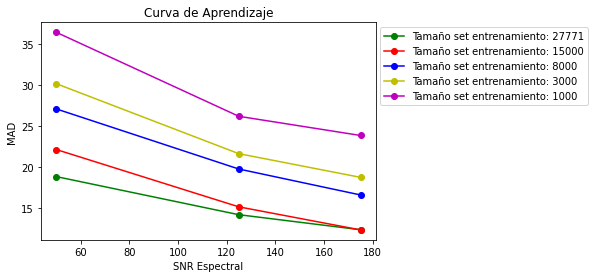

In [83]:
snr_list = [50,125,175]

plt.plot(snr_list, mad_test_m7_snr, "og-", label = "Tamaño set entrenamiento: 27771")
plt.plot(snr_list, mad_test_m6_snr, "or-", label = "Tamaño set entrenamiento: 15000")
plt.plot(snr_list, mad_test_m5_snr, "ob-", label = "Tamaño set entrenamiento: 8000")
plt.plot(snr_list, mad_test_m4_snr, "oy-", label = "Tamaño set entrenamiento: 3000")
plt.plot(snr_list, mad_test_m3_snr, "om-", label = "Tamaño set entrenamiento: 1000")

plt.legend(loc= "upper right", bbox_to_anchor=(1.65, 1))
plt.ylabel("MAD")
#plt.yscale("log")
plt.xlabel("SNR Espectral")
plt.title("Curva de Aprendizaje")
plt.show()

In [52]:
from astropy.stats import mad_std
mad_std((astroNN_pc[good_idx][idx5] - rc_pc[idx6]) / astroNN_pc[good_idx][idx5]) * 100

In [60]:
mad_std((Y_test_snr_0_100 - Y_hat_m3_snr_0_100 )/ Y_test_snr_0_100)*100

36.48886125586241